###### Università degli Studi di Milano, Data Science and Economics Master Degree

# Multi-agent reinforcement learning

### Luigi Foscari

<small>see sections 1.1 to 1.4 and 5.2 to 5.4 of [Multi-Agent Reinforcement Learning: Foundations and Modern Approaches](https://www.marl-book.com) for a more in-depth overview. Consider watching this [YouTube video](https://www.youtube.com/watch?v=QfYx5q0Q75M) by the book's author which provides a great introduction.</small>

So far we tackled the problem of learning an optimal policy for a single agent inside a MDP, we now shift our focus towards contexts in which there are _multiple_ agents acting in the MDP with (possibly) different goals. For example, consider a fleet of autonomous vehicles with the goal of driving as quickly and safely as possible, a team of players in a competitive videogame or a group of automated traders that manage each their own investments in a public market.

**How does the addition of other learning agents change what we learned so far?**

_See the available [environments](https://pettingzoo.farama.org/environments/classic/) from the PettinZoo library for more examples_

A **multi-agent system** is composed of an environment and multiple decision-making agents, also called _players_, that interact in the environment to achieve certain goals. The environment evolves during play according the player's actions and optionally randomness. 

**Multi-agent reinforcement learning** or **MARL** tackles learning in such systems by devising algorithms that let the players refine their respective strategies, which can be collaborative, competitive or a mix of the two.

At the start of a round of the game, each player sees the state of the environment and picks an action, the round ends after every player has chosen an action, then the envoriment evolves accordingly and each player collects their reward to update their respective policy.

<img src="imgs/environment-marl.png" width="600" style="display: block; margin: 0 auto"/>

From the point of view of the agent, little has changed, they still have a set of actions, a policy, an enviroment and the goal of optimizing their policy.
What changed? The difference lies in the fact that **the immediate reward achieved by any player depends on the actions of the other players on the same round**.

For example consider a group of learning agents playing football, when a goal is scored, the success is tied to the actions of all the players, not only of the player that last kicked the ball. This introduces the problem of understanding how much of each player contributed, this is called **multi-agent credit assignment**.

Another issue that arises in MARL is the dependence on the number of agents, when considering games with a thousands of players, our learning procedure might struggle. When dealing with multiple agents, the algorithms will need to scale well with the number of agents.

### Central learning
One natural approach to the problem of learning with multiple agents is to use a single learning procedure (e.g. Q-learning) which learns the best strategy for each player, like a conductor in an orchestra, we shall call this algorithm the _maestro_. If each player $i \in \{1, \dots, N\}$ has an action space $\mathcal{A}_i$, then the maestro will have action space $\mathcal{A} = \mathcal{A}_1 \times \dots \times \mathcal{A}_N$, the state space is $\mathcal{S}$ and on each round the maestro chooses an action $a \in \mathcal{A}$ (where $a = (a_1, \dots, a_N)$ corresponds to actions for every single player) and distributes the correponding actions to the players, which they dutifully play as instructed. This approach can work, but it has a number of drawbacks:
- The actions space of the maestro can grows very quickly, if for example each player's action space has fixed size $A$, then the action space of the maestro has size $A^N$, which is exponential in the number of players. If each agent used an independent learning algorithm, each would have to manage only $A$ actions.
- In certain context centralized learning is not allowed, for example with autonomous driving or when the details of each agent are not known.
- Each player might have a different reward function (i.e. a different objective) and the maestro should take this into account in order to devise a complex learning objective suited to the underlying players. In practice the reward of each player might not be known and even if they are known, it might be non-trivial or downright impossible to aggregate the given rewards into a single one that can be fed to the maestro's learning procedure to achieve the desired solution concept, more on this in the next lesson.

### Independent learning
The opposite approach is for each agent to learn using an independent learning procedure, removing the need for a centralized authority, its dependency on the number of players and the issue of handling the rewards. This approach has proven to be much more successfull, but classical algorithm from RL might not be suited to the task.

#### Independent Q-learning
Consider the case in which each agents learns using the standard Q-learning algorithm. On each round, each player $i \in \{1, \dots, N\}$ observes a state $s \in \mathcal{S}$ and picks an action $a_i \in \mathcal{A}_i$, after each player picked their action $a_1, \dots, a_N$, the next state $s' = \tau(s, a)$ transitions according the joint action $a = (a_1, \dots, a_N)$ and each player receives reward $r_i$, which is used to update their respective value function $Q_i$ as
$$
	Q_i(s, a_i) =
		(1 - \alpha) Q_i(s, a_i)
		+ \alpha ( r_i + \gamma \max_{a'_i \in \mathcal{A}_i} Q_i(s', a'_i) )
$$
Because the transition from one state to another depends on the joint action $a = (a_1, \dots, a_N)$ and not on a single action, from a single player's point of view the transition function of the MDP depends on the other players actions, because the other players actively learn and are therefore non-stationary in their choice of action, the transition function is non-stationary. In general this means that independent learning does not converge, but in certains classes of games, it does.

### The goal of multi-agent reinforcement learning
In the classic RL case, a policy is optimal if it maximises the _return_, defined as the sum of the immediate reward obtained during play, in the multi-agent case, any player's return depends on the other players' actions and ultimately depends on their policies.

**If the return of a policy depends on the other policies, how do we define optimality?** There is no fixed answer to this question, in fact it depends on the underlying context and the objective of the learning procedure, for now we only focus on modeling the problem. To understand the different solutions concepts for MARL we will rely on game-theorical arguments.

In the meantime, we can evaluate the performance of a learning algorithm by its convergence rate to a specific solution concept, viz. we define a specific policy for each player to which we want our algorithm to converge to and we try to understand
1. If the learning algorithm converges to the proposed solution (which the algorithm does not know).
2. If true, how fast is the convergence?

For example, going back to the football example, before the start of the game we decide _roughly_ how we want the players to play by defining different roles, which translate to different behaviours. Afterward we pick a learning algorithm and try to understand if the players actually learn to play as we intended.

This might seem very accidental, how can we be sure that the algorithm will converge to these behaviours that we randomly picked? This can be achieved by choosing these behaviours wisely from very well studied solution concepts, which we will tackle in the next lesson.

### Welcome to the PettingZoo
The Farama foundation, who maintains the Gymnasium library, work also on a MARL-oriented library called [PettingZoo](https://pettingzoo.farama.org/). They share the same interface, which is very useful when, hypothetically, you have been following a course using Gym and now you need to abruptly switch library to cover MARL topics.

Now a couple of examples: first the simple competitive tic-tac-toe game and then a collaborative combat game with players with different actions.

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np

def visualize(render):
	clear_output(wait=True)
	plt.imshow(render)
	plt.axis("off")
	plt.show()

In [ ]:
from pettingzoo.classic import tictactoe_v3

env = tictactoe_v3.env(render_mode = "rgb_array")
env.reset(seed = 42)

for agent in env.agent_iter():
	obs, reward, termination, truncation, info = env.last()
	if termination or truncation:
		action = None
	else:
		legal_moves = obs["action_mask"]
		action = env.action_space(agent).sample(legal_moves)

	visualize(env.render())
	env.step(action)

env.close()

In [ ]:
from agents.tabular import QLearning

# We need two encoding-decoding functions to get from the original action (or state)
# space to an action (or state) space which is hashable by Python dictionaries.

def encode(xs: np.ndarray) -> tuple[int]:
	return tuple(xs.flatten())

def decode(xs: tuple[int], size = (1, )) -> np.ndarray:
	if len(xs) == 1: return xs[0]
	return np.array(xs).reshape(size)

# Now redefine the QLearning class to use these functions and also to pick the actions
# from the specific agent's action space, this last change is foundamental when working
# with MARL.

class MultiAgentQLearning(QLearning):
	def greedy(self, state, agent):
		default_action = encode(self.mdp.action_space(agent).sample())
		action = max(self.Q[state], key=self.Q[state].get, default=default_action)
		return decode(action)

	def explore(self, state, agent):
		if np.random.uniform() < self.epsilon:
			return self.mdp.action_space(agent).sample()
		else:
			return self.greedy(state, agent)

In [ ]:
from pettingzoo.mpe import simple_push_v3
from tqdm import trange

EPISODES = 500
MAX_ITERATIONS = 500
SAVE_EVERY = 10

# env = pistonball_v6.parallel_env(
# 	n_pistons = 5,
# 	max_cycles = MAX_ITERATIONS, # after these many cycles the simulation stops
# 	continuous = False, # the pistons can move down (0), stay still (1) or move up (2)
# 	random_drop = True, # ball appears randomly on the field
# 	render_mode = "rgb_array"
# )

env = simple_push_v3.parallel_env(
	max_cycles = MAX_ITERATIONS,
	continuous_actions = False,
	render_mode = "rgb_array"
)

algorithms = {
	"agent_0": MultiAgentQLearning(env),
	"adversary_0": MultiAgentQLearning(env, final_epsilon=1), # random
	# for agent in env.possible_agents
}

# Set the epsilon decay value
for agent in algorithms.values():
	agent.e_decay = agent.epsilon / (MAX_ITERATIONS / 2)

for episode in trange(EPISODES):
	observations, _ = env.reset()

	observations_encoded = {
		agent: encode(observations[agent])
		for agent in env.possible_agents
	}

	# Keep track of the average error for each agent
	episode_error = {agent: [] for agent in env.possible_agents}

	while env.agents:
		actions = {
			agent: algorithms[agent].explore(observations_encoded[agent], agent)
			for agent in env.agents
		}
		
		# visualize(env.render())
		new_observations, rewards, terminations, truncations, infos = env.step(actions)

		new_observations_encoded = {
			agent: encode(new_observations[agent])
			for agent in env.possible_agents
		}

		for agent, algorithm in algorithms.items():
			# Encode the states and action
			error = algorithm.update(
				state = observations_encoded[agent],
				action = encode(actions[agent]),
				reward = rewards[agent],
				terminated = terminations[agent],
				s_prime = new_observations_encoded[agent]
			)
			episode_error[agent].append(error)

		observations_encoded = new_observations_encoded

	if episode % SAVE_EVERY == 0:
		for agent, algorithm in algorithms.items():
			# algorithm.history.append(algorithm.Q.copy())
			algorithm.error.append(np.average(episode_error[agent]))

	for algorithm in algorithms.values():
		algorithm.decay_epsilon()
		
env.close()

In [ ]:
X = range(1, 1 + EPISODES // SAVE_EVERY)

for agent, algorithm in algorithms.items():
	plt.plot(X, algorithm.error, label=agent)
plt.legend()
plt.show()

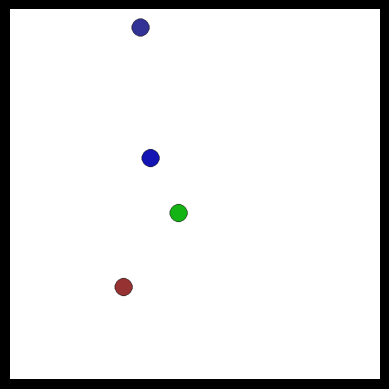

In [ ]:
env = simple_push_v3.parallel_env(
	max_cycles = 100,
	continuous_actions = False,
	render_mode = "rgb_array"
)

observations, _ = env.reset()

while env.agents:
	actions = {agent: env.action_space(agent).sample() for agent in env.agents}

	visualize(env.render())
	observations, rewards, terminations, truncations, _ = env.step(actions)
env.close()